In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
from collections import OrderedDict
from time import time

import utils
import plotter


%matplotlib inline
%config InlineBackend.figure_format='retina'

PATH = os.getcwd()
RNG_SEED = 42
np.random.seed(seed=RNG_SEED)

In [2]:
data_path_jarvis = os.path.join(PATH, './data/descriptors/jarvis.bin')
data_path_magpie = os.path.join(PATH, './data/descriptors/magpie.bin')
data_path_mat2vec = os.path.join(PATH, './data/descriptors/mat2vec.bin')
data_path_oliynyk = os.path.join(PATH, './data/descriptors/oliynyk.bin')
data_path_onehot = os.path.join(PATH, './data/descriptors/onehot.bin')
data_path_random_200 = os.path.join(PATH, './data/descriptors/random_200.bin')

data_path = [data_path_jarvis, data_path_magpie, data_path_mat2vec, data_path_oliynyk, data_path_onehot, data_path_random_200]
x_value_raw = {}
x_label = ['jarvis', 'magpie', 'mat2vec', 'oliynyk', 'onehot', 'random_200']

for path, label in zip(data_path, x_label):
    with open(path, 'rb') as f:
        x_value_raw[label] = pickle.load(f)

In [3]:
#Normalize data
from sklearn.preprocessing import StandardScaler
x_value_scaled = {}
for key, value in x_value_raw.items():
    scaler = StandardScaler()
    x_value_scaled[key] = (pd.DataFrame(scaler.fit_transform(value[0]), columns=value[0].columns), value[1])

In [4]:
from sklearn.decomposition import KernelPCA
x_value = {}
for key, value in x_value_scaled.items():
    n_components = min(value[0].shape[1], 200) #20~200 20steps
    kpca = KernelPCA(n_components=n_components, kernel='poly')
    x_value[key] = (pd.DataFrame(kpca.fit_transform(value[0])), value[1])

In [5]:
for key, value in x_value.items():
    print(f'{key}: {value[0].shape[1]}')

jarvis: 200
magpie: 154
mat2vec: 200
oliynyk: 200
onehot: 200
random_200: 200


In [6]:
df_classics = pd.DataFrame(columns=[
        'feature',
        'model_name',
        'model',
        'fit_time',
        'r2_train',
        'mae_train',
        'rmse_train',
        'r2_val',
        'mae_val',
        'rmse_val',
        'y_test',
        'predict',])

In [7]:
scheme_label = ['jarvis', 'magpie', 'mat2vec', 'oliynyk', 'onehot', 'random_200']
classic_models = OrderedDict()
from time import time
for label in tqdm(scheme_label):
    models = [RandomForestRegressor(), GradientBoostingRegressor()]
    for model in models:
        X, y = x_value[label][0], x_value[label][1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RNG_SEED)
        model, result_dict = utils.fit_evaluate_model(model, X_train, y_train, X_test, y_test, label)
        df_classics = utils.append_result_df(df_classics, result_dict)
        classic_models = utils.append_model_dict(classic_models, model, label)

100%|█████████████████████████████████████████████| 6/6 [01:04<00:00, 10.74s/it]


RandomForestRegressor, jarvis has 0 anomalies
GradientBoostingRegressor, jarvis has 0 anomalies
RandomForestRegressor, magpie has 0 anomalies
GradientBoostingRegressor, magpie has 0 anomalies
RandomForestRegressor, mat2vec has 0 anomalies
GradientBoostingRegressor, mat2vec has 0 anomalies
RandomForestRegressor, oliynyk has 0 anomalies
GradientBoostingRegressor, oliynyk has 0 anomalies
RandomForestRegressor, onehot has 0 anomalies
GradientBoostingRegressor, onehot has 0 anomalies
RandomForestRegressor, random_200 has 0 anomalies
GradientBoostingRegressor, random_200 has 0 anomalies


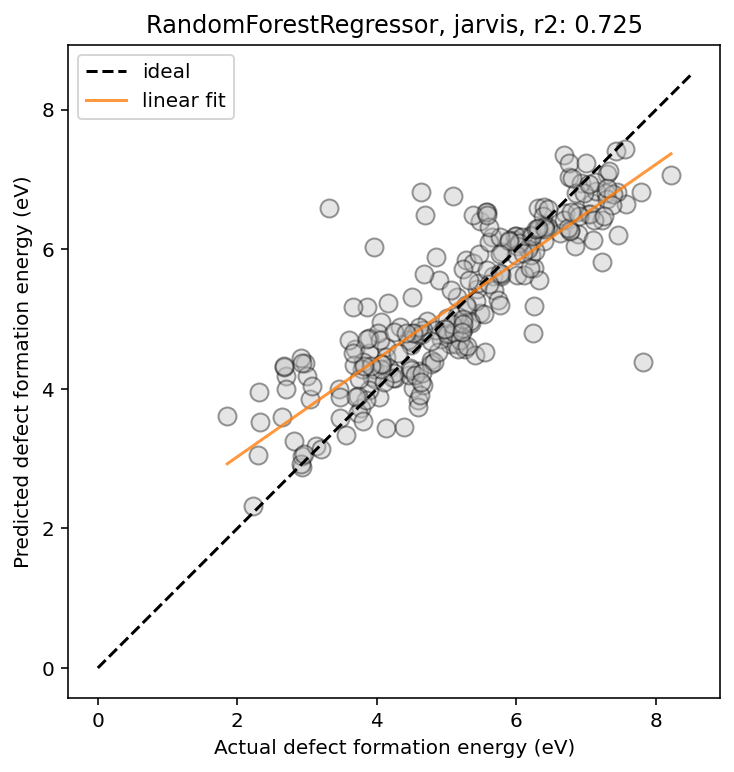

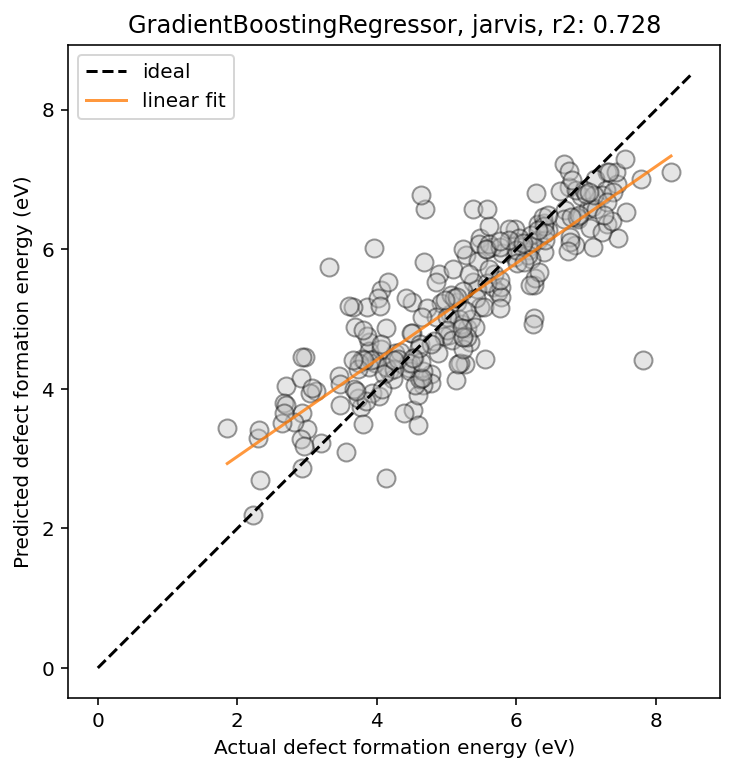

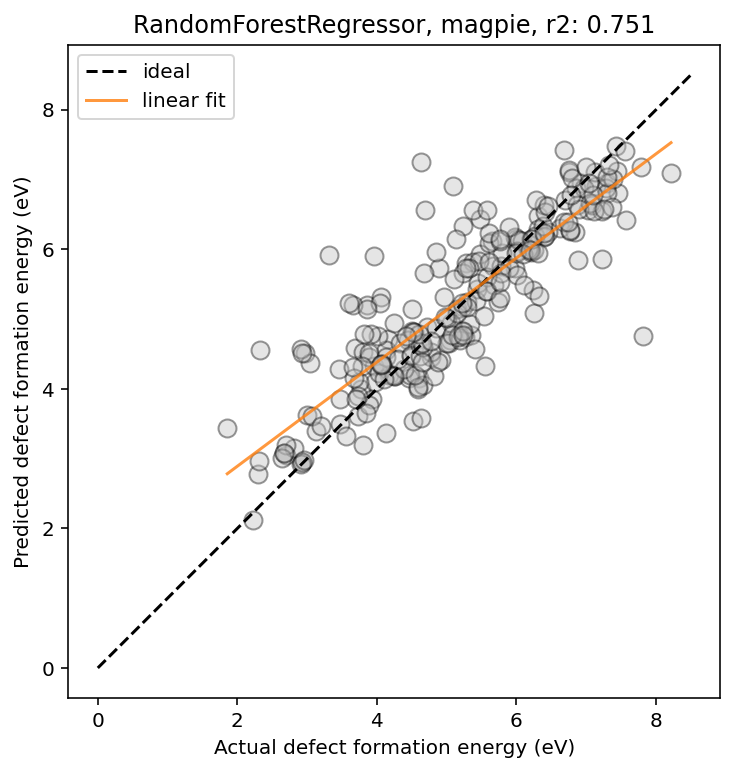

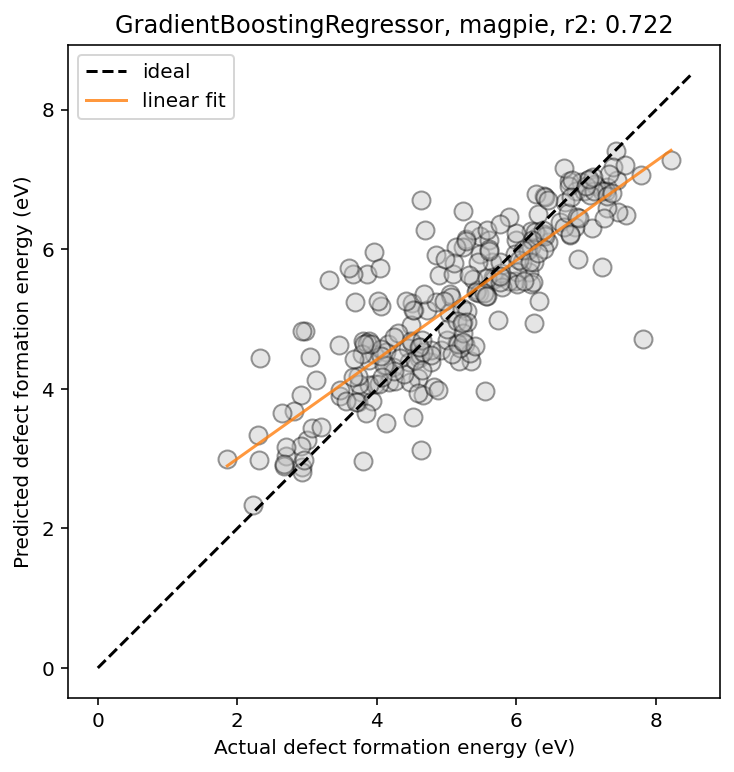

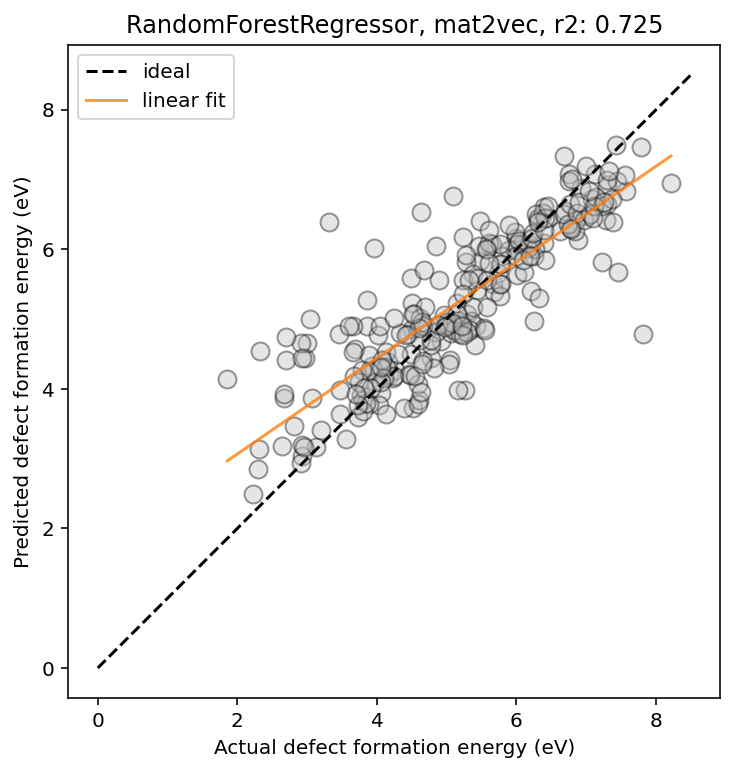

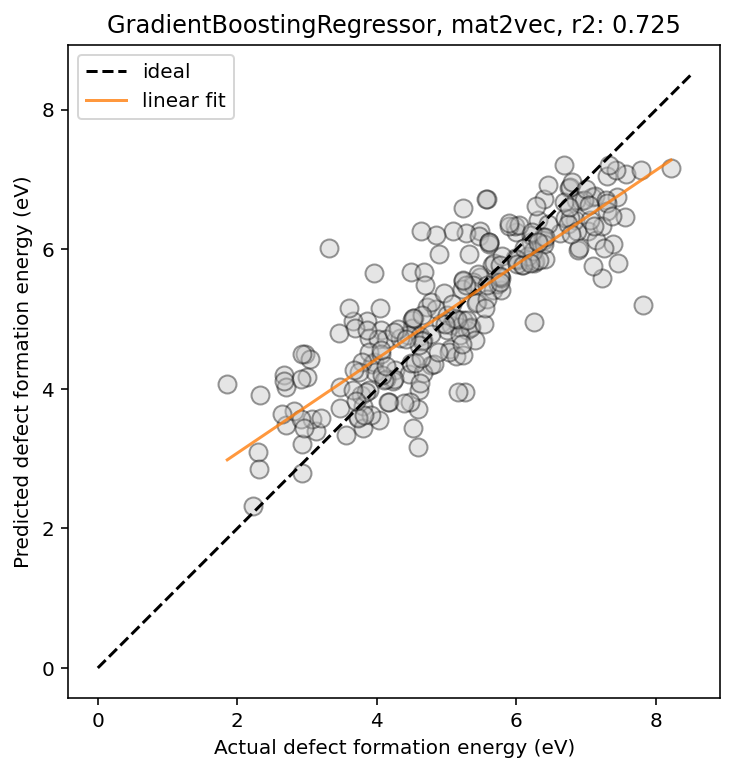

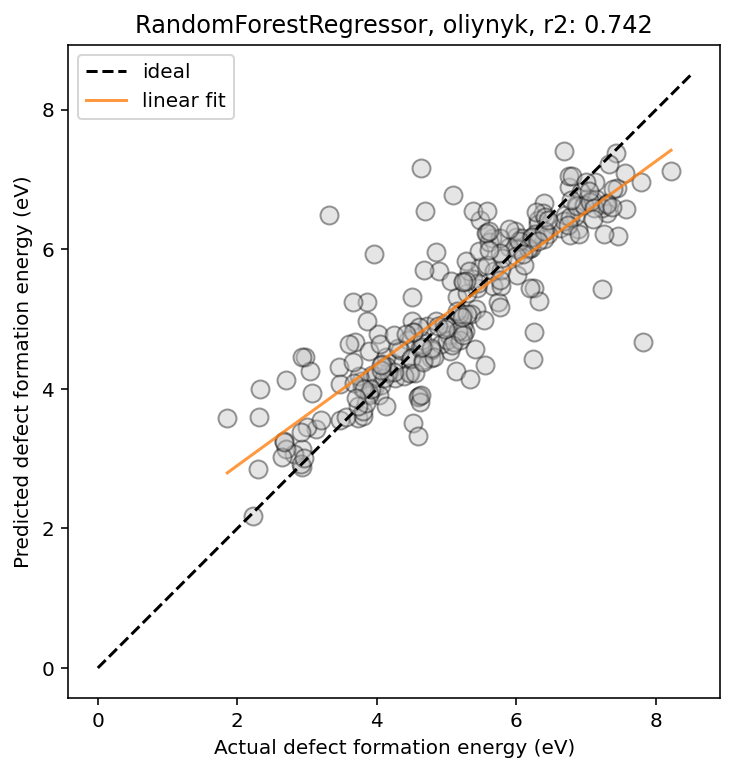

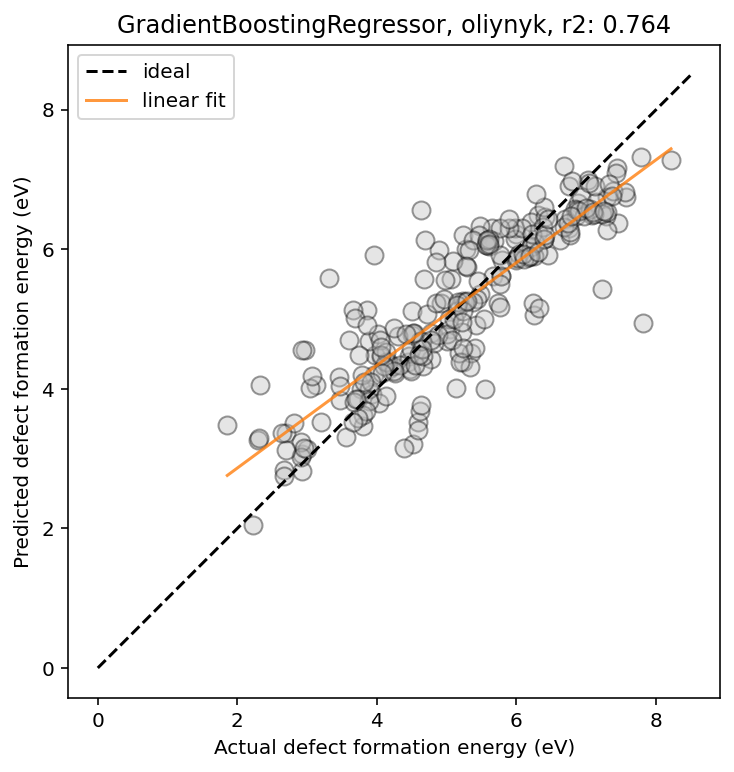

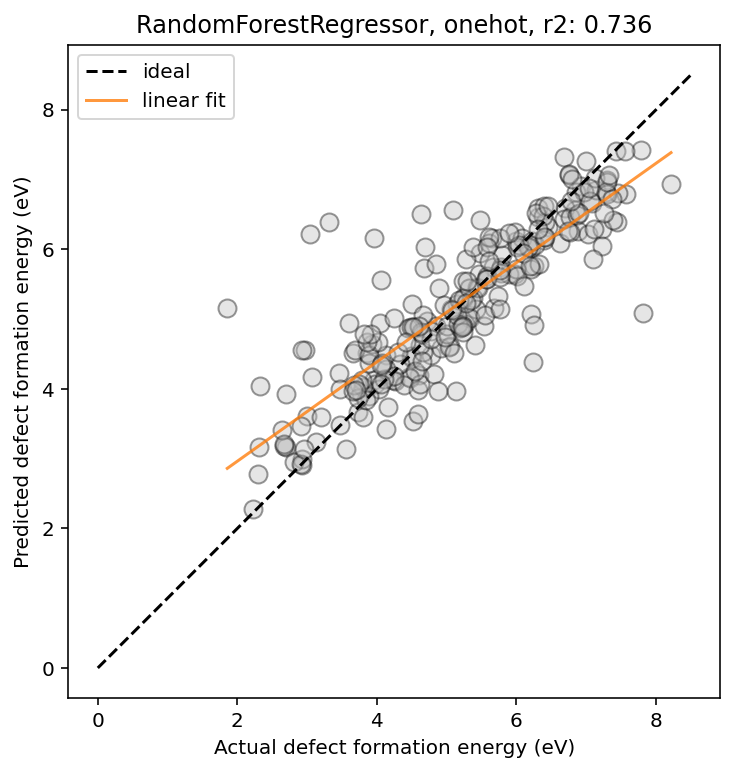

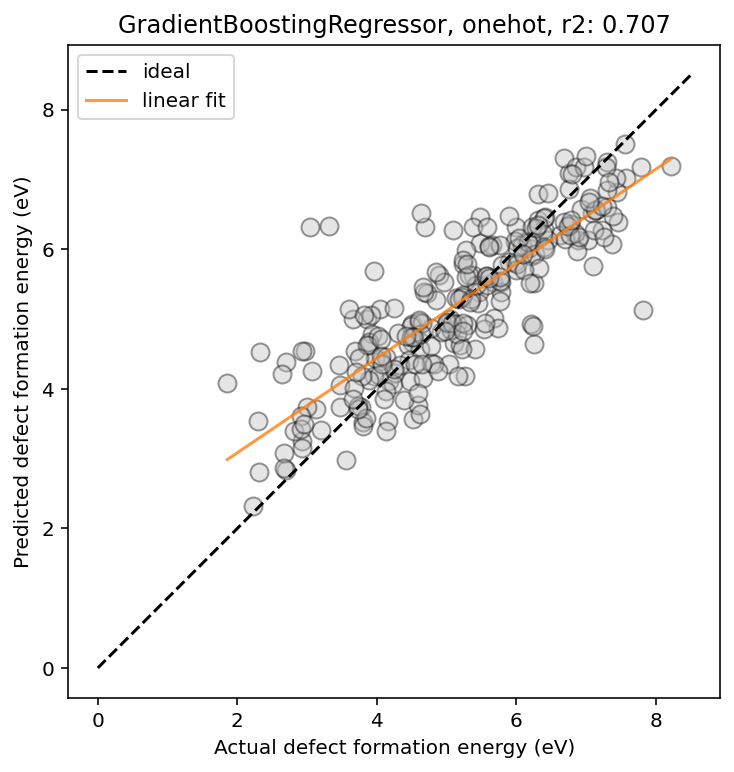

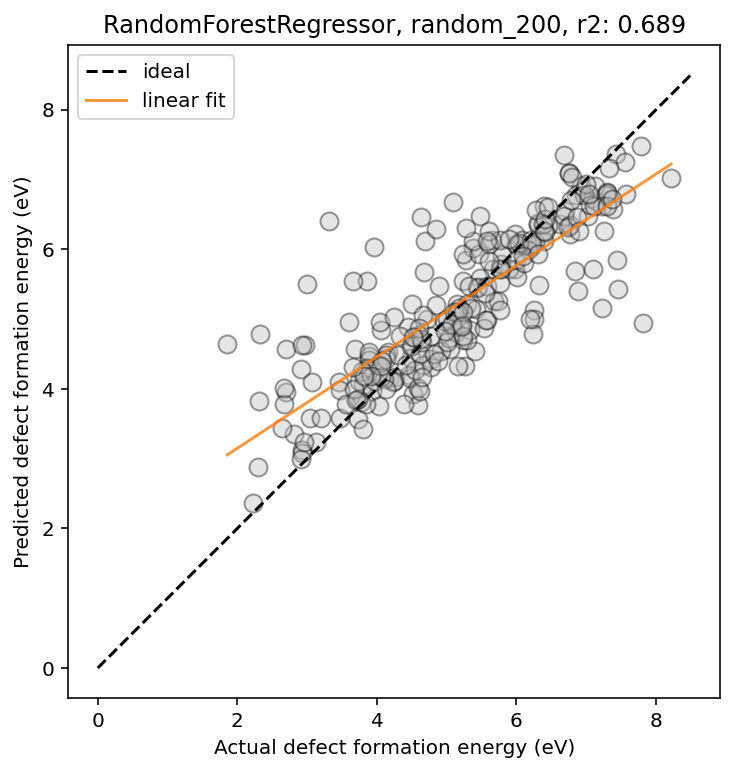

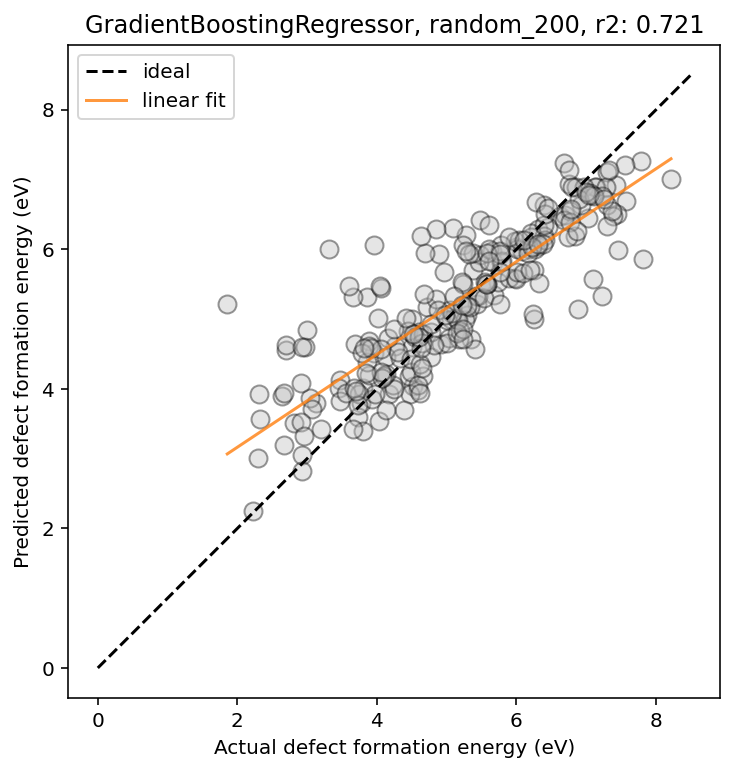

In [8]:
for row in range(df_classics.shape[0]):
    feature_name = df_classics.iloc[row]['feature']
    model = df_classics.iloc[row]['model_name']
    y_act_val = df_classics['y_test'][row]
    y_pred_val = df_classics['predict'][row]

    y_act_val, y_pred_val, anomaly_cnt = plotter.remove_anomalies(y_act_val, y_pred_val)
    print(f'{model}, {feature_name} has {anomaly_cnt} anomalies')
    plot = plotter.plot_pred_act(y_act_val, y_pred_val, feature_name, model, 
                                 reg_line=True, label='defect formation energy (eV)')